In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker.predictor import csv_serializer   
from sagemaker import get_execution_role
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 

ModuleNotFoundError: No module named 'boto3'

## Let's first create our Sagemaker session and role

In [ ]:
# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()
prefix = 'sagemaker/ml-intro'

my_region = boto3.session.Session().region_name # set the region of the instance

print("Success - the MySageMakerInstance is in the " + my_region + " region.")


## Downloading dataset

In [10]:
bucket_name = 'labut'
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [13]:
try:
  urllib.request.urlretrieve ("https://labz6.s3-us-west-1.amazonaws.com/data_banknote_authentication.txt", "data_banknote_authentication.txt")
  print('Success: downloaded bank_clean.csv.')
except Exception as e:
  print('Data load error: ',e)

try:
  df = pd.read_csv('./data_banknote_authentication.txt', sep=",", header=None)
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded bank_clean.csv.
Success: Data loaded into dataframe.


## Task 1. => Exploratory data analysis 
Make Scatter plots of features (of all possible permutations) and use different colors to represent class 0 (genuine) and 1 (forged)

In [12]:
# # Read data by using pandas lib
# df = pd.read_csv('data_banknote_authentication.txt', sep=",", header=None)

In [14]:
def make_scatter_plots(x,y,data_type,x_label,y_label):
    """
        Function to plot one scatter 
        Agruments: x: x data
                   y: y data
                   data_type: type of (x,y) -> 0 or 1
        Return: no return
    """
    pos_data_type_1 = 0
    for i in range (0,len(data_type)):
        if data_type[i] == 1:
            pos_data_type_1 = i
            break
            
    fig, axs = plt.subplots(1, 2, figsize=(15,8), sharey=True)
    axs[0].scatter(x[:pos_data_type_1], y[:pos_data_type_1], c='b', label = 'genuine')
    axs[0].scatter(x[pos_data_type_1:], y[pos_data_type_1:], c='r', label = 'forged')
    axs[0].set_title(y_label+'vs.'+x_label)
    axs[0].set_xlabel(x_label)
    axs[0].set_ylabel(y_label)
    axs[0].legend()
    
    axs[1].scatter(y[:pos_data_type_1], x[:pos_data_type_1], c='b', label = 'genuine')
    axs[1].scatter(y[pos_data_type_1:], x[pos_data_type_1:], c='r', label = 'forged')
    axs[1].set_title(x_label+'vs.'+y_label)
    axs[1].set_xlabel(y_label)
    axs[1].set_ylabel(x_label)
    axs[1].legend()

In [17]:
def plot_all_scaters(df):
    """
        Function calls make_scatter_plots() to plot all possible scatters
        Arguments: df: type(pd data frame) 
        Return: no return
    """
    keys = list(df.keys())
    labels = ['Skewness', 'Kurtosis', 'Entropy', 'Variance']
    for i in range(0,len(keys)-1):
        for j in range(i,len(keys)-1):
            if i is not j:
                make_scatter_plots(df[i],df[j],df[4],labels[i],labels[j])

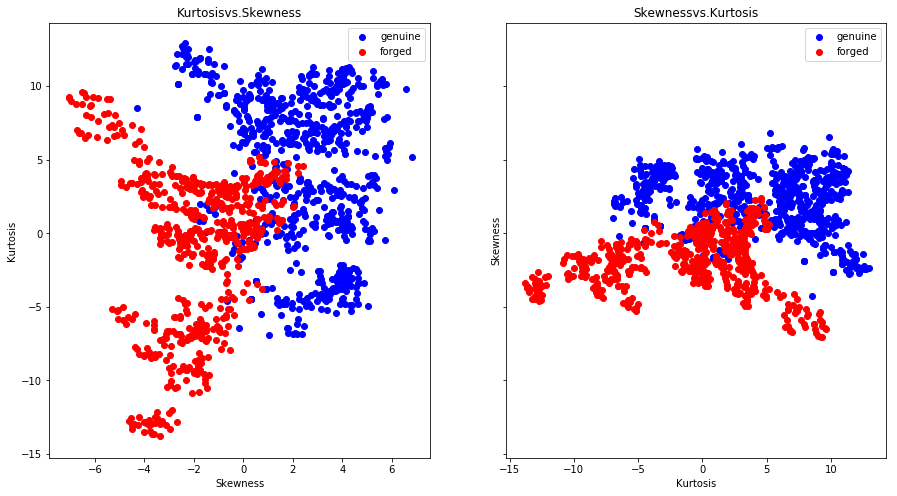

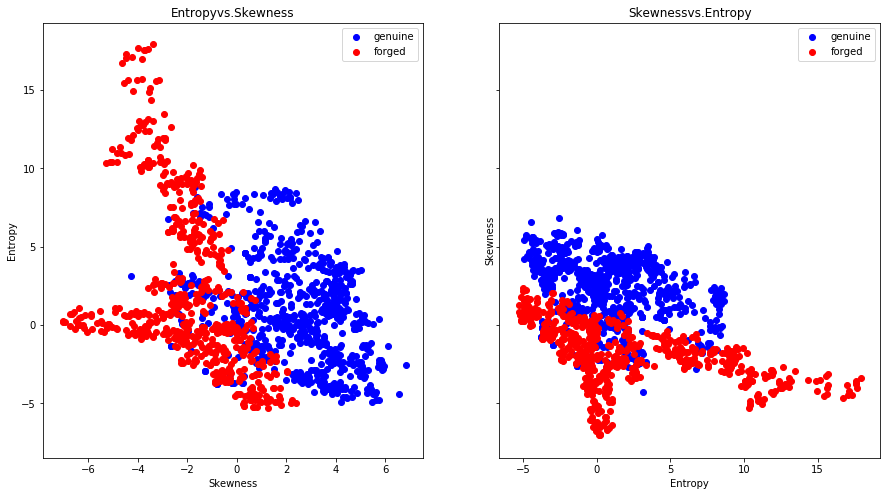

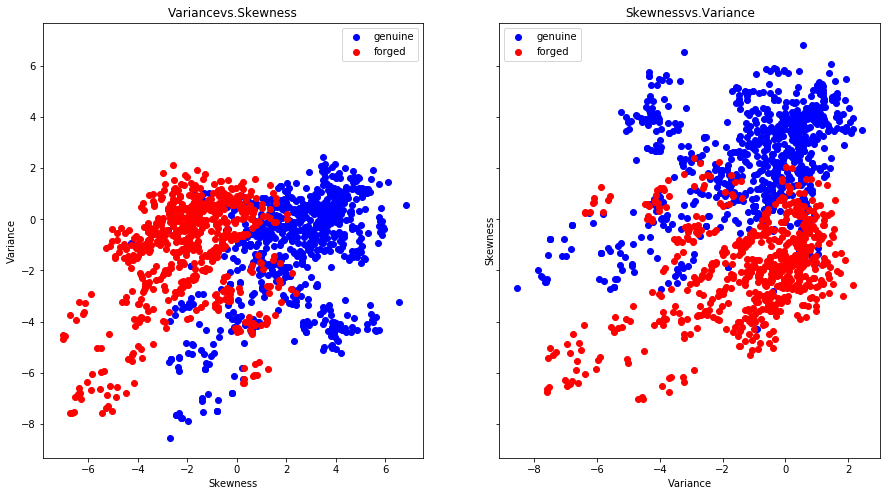

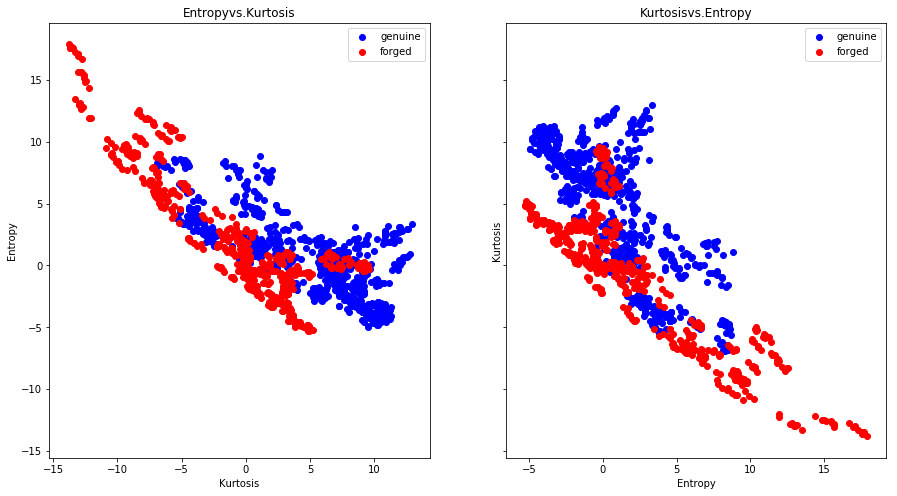

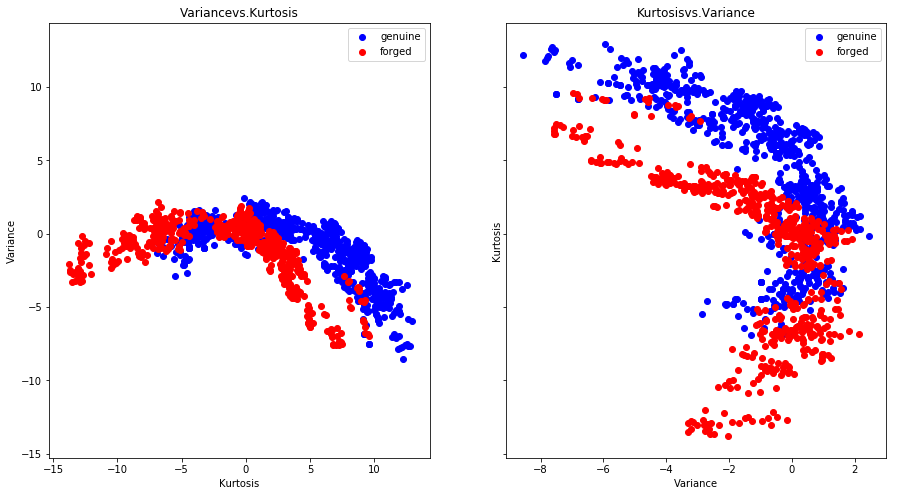

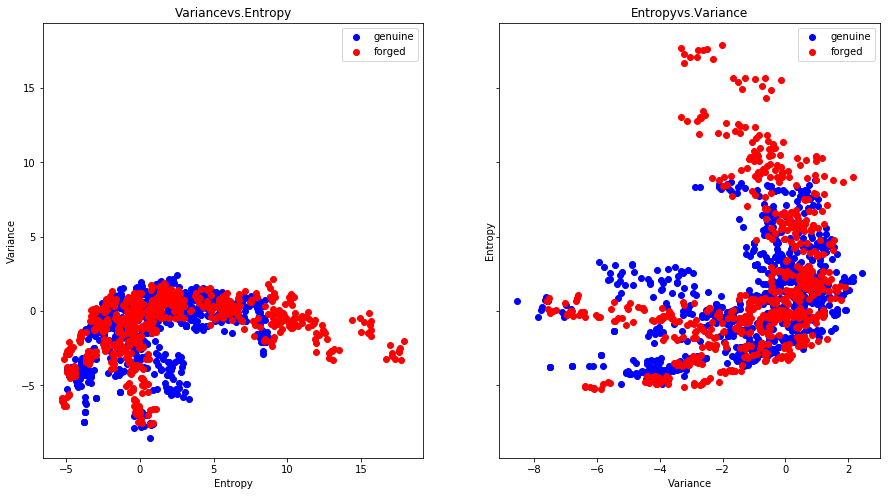

In [18]:
plot_all_scaters(df)

## Task 2. => Selection of a suitable machine learning algorithm 
Explore several devised algorithms and use your analysis to choose one. Explain your choice through proper reasoning.
There are several ML algorithms like Logistic regression, Support vector machines, Bayesian
classifiers etc.

## Logistic Regression
Logistic regression is best suited for binary classification: data sets where y = 0 or 1, where 1 denotes the default class. For example, in predicting whether an event will occur or not, there are only two possibilities: that it occurs (which we denote as 1) or that it does not (0). So if we were predicting whether a patient was sick, we would label sick patients using the value of 1 in our data set.

## Support Vector Machines (SVM)
A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

## Bayesian classifiers
A Bayesian classifier is based on the idea that the role of a (natural) class is to predict the values of features for members of that class. Examples are grouped in classes because they have common values for the features. Such classes are often called natural kinds. In this section, the target feature corresponds to a discrete class, which is not necessarily binary.
The idea behind a Bayesian classifier is that, if an agent knows the class, it can predict the values of the other features. If it does not know the class, Bayes' rule can be used to predict the class given (some of) the feature values. In a Bayesian classifier, the learning agent builds a probabilistic model of the features and uses that model to predict the classification of a new example.

We decide to choose SVM as the algorithm to use in this problem. There are four advantages of using SVM:
    1. Effective in high dimensional spaces. (We have a 4 dimensional data)
    2. Still effective in cases where number of dimensions is greater than the number of samples
    3. Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
    4. Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

## Task 3. => Training and Testing
Select the first 200 rows of Class 0 and the first 200 rows of Class 1 as the test set and the rest of the data as the training set. Build a model based on your chosen algorithm, train and test the model. Report the training accuracy, test accuracy and test F-score.

In [19]:
def data_generator(df):
    """
        Function to generate training data and testing data
        Argument: df dataframe (type pd)
        Returns: 
                x_train_shuffled
                y_train_shuffled
                x_test_shuffled
                y_test_shuffled
    """
    pos_data_type_1 = 0
    for i in range (0,len(df[4])):
        if df[4][i] == 1:
            pos_data_type_1 = i
            break
    
    # Generate Data
    
    length = len(df)
    num_elements = len(df.keys())
    
    x_train = np.zeros((length-400,num_elements-1))
    y_train = np.zeros((length-400,1))
    x_test = np.zeros((400,num_elements-1))
    y_test = np.zeros((400,1))
    
    for i in range (0,num_elements-1):
        x_test[0:200,i] = df[i][0:200]
        x_test[200:,i] = df[i][pos_data_type_1:pos_data_type_1+200]
        x_train[0:pos_data_type_1-200,i] = df[i][200:pos_data_type_1]
        x_train[pos_data_type_1-200:,i] = df[i][pos_data_type_1+200:]
    
    y_test[0:200,0] = df[4][0:200]
    y_test[200:,0] = df[4][pos_data_type_1:pos_data_type_1+200]
    y_train[0:pos_data_type_1-200,0] = df[4][200:pos_data_type_1]
    y_train[pos_data_type_1-200:,0] = df[4][pos_data_type_1+200:]
    
    #  Shuffle
    pi_trained = np.random.permutation(x_train.shape[0])
    x_train_shuffled = x_train[pi_trained]
    y_train_shuffled = y_train[pi_trained]
    y_train_shuffled = y_train_shuffled.reshape(y_train_shuffled.shape[0],)
    
    pi_test = np.random.permutation(x_test.shape[0])
    x_test_shuffled = x_test[pi_test]
    y_test_shuffled = y_test[pi_test]
    y_test_shuffled = y_test_shuffled.reshape(y_test_shuffled.shape[0],)
    
    return x_train_shuffled, y_train_shuffled, x_test_shuffled, y_test_shuffled
    

In [20]:
# SVM
x_train, y_train, x_test, y_test = data_generator(df)
svm_clf = svm.SVC(gamma='scale',verbose=False)
svm_clf.fit(x_train, y_train) 
svm_train_score = svm_clf.score(x_train,y_train)
svm_test_score = svm_clf.score(x_test,y_test)

svm_y_pred = svm_clf.predict(x_test)
svm_f_score = f1_score(y_test,svm_y_pred)

print("SVM Model:")
print("Training score is: {}".format(svm_train_score))
print("Test score is: {}".format(svm_test_score))
print("Test f-score is: {}".format(svm_f_score))

SVM Model:
Training score is: 1.0
Test score is: 1.0
Test f-score is: 1.0


In [21]:
# Logistic Regression
x_train, y_train, x_test, y_test = data_generator(df)
lr_clf = LogisticRegression(random_state=50,solver='liblinear').fit(x_train, y_train)
lr_train_score = svm_clf.score(x_train,y_train)
lr_test_score = svm_clf.score(x_test,y_test)

lr_y_pred = svm_clf.predict(x_test)
lr_f_score = f1_score(y_test,lr_y_pred)

print("Logistic Regression Model:")
print("Training score is: {}".format(lr_train_score))
print("Test score is: {}".format(lr_test_score))
print("Test f-score is: {}".format(lr_f_score))

Logistic Regression Model:
Training score is: 1.0
Test score is: 1.0
Test f-score is: 1.0
